## Vehicle Detection + Advanced Lane Finding

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
* Normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use trained classifier to search for vehicles in images.
* Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
* Add Advanced Lane Finding pipeline.
---

In [1]:
import numpy as np                 # NumPy
import cv2                         # openCV
import glob                        # Filename pattern matching
import matplotlib.pyplot as plt    # 2D plotting
import matplotlib.image as mpimg
import pickle
from tqdm import tqdm
# Visualizations will be shown in the notebook
%matplotlib inline

## Compute the camera calibration points using chessboard images

In [2]:
def calculate_mtx_dist(images, nx = 9, ny = 6, verbose = False):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners

    imgs = images

    if verbose:
      imgs = tqdm(images)

    for idx, fname in enumerate(imgs):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # print('ret =', ret)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            if verbose:
              cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
              write_name = 'output_images/corners_found/corners_found'+str(idx)+'.jpg'
              cv2.imwrite(write_name, img)
            # cv2.imshow('img', img)
            # cv2.waitKey(500)

    # Test undistortion on an image
    # img = cv2.imread('camera_cal/calibration1.jpg')
    img = cv2.imread(images[0])
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    return mtx, dist

nx = 9
ny = 6

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

mtx_dist_save_file = 'dist_pickle.p'

# Calculate calibration matrix
mtx, dist = calculate_mtx_dist(images, nx=9, ny=6, verbose=True)


# Save Distortion matrix and coefficient
with open(mtx_dist_save_file, 'wb') as f:
    saved_obj = {"mtx": mtx, "dist" : dist}
    pickle.dump(saved_obj, f)


# Load Saved Camera Matrix and Distortion Coefficients
dist_pickle = pickle.load(open(mtx_dist_save_file, "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.19it/s]


## Distortion correction

In [3]:
def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

In [4]:
# For universal plotting of results
def plot_row2(img1, img2, label_1, label_2, graysc=True):
    # Plot the result (1 row with 2 images)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=16)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform

Pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above.

The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

In [5]:
# Applies an image mask
# Only keeps the region of the image defined by the polygon formed from `vertices`.
# The rest of the image is set to black.
def region_of_interest(img, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def perspective_transform(img, inv=False):
    img_size = (img.shape[1], img.shape[0])
    width, height = img_size
    offset = 200
    src = np.float32([
        [  588,   446 ],
        [  691,   446 ],
        [ 1126,   673 ],
        [  153 ,   673 ]])
    dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(img,M, (width, height))
    return binary_warped, M, Minv

# PERSPECTIVE TRANSFORM
def warp(thresholded):
    warped_img, M, Minv = perspective_transform(thresholded)
    # Define image mask (polygon of interest)
    imshape = warped_img.shape
    vertices = np.array([[(200, imshape[0]), (200, 0), (imshape[1] - 200, 0), 
                      (imshape[1]-200, imshape[0])]], dtype=np.int32)
    masked_img = region_of_interest(warped_img, vertices)
    return masked_img, M, Minv, warped_img

## Image Thresholding


In [6]:
# COLOR / GRADIENT THRESHOLD
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def threshold(img, color=False, mag_dir_thresh=False):
    """Threshhold image on saturation channel and 
    using magnitude gradient"""
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    
    ## White Color
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    ## Yellow Color
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
    
    combined_binary = np.zeros_like(white_mask)
    
    # Dir Mag Threshold
    if mag_dir_thresh:
        dir_mask = dir_threshold(img)
        mag_mask = mag_thresh(img)
        combined_binary[((dir_mask == 1) & (mag_mask == 1))] = 255
        
    if color:
        return np.dstack((white_mask, yellow_mask, combined_binary))
    
    else:
        combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 255
        combined_binary[(combined_binary == 255)] = 1
        return combined_binary

## Detect lane pixels and fit to find lane boundary.

In [7]:
import collections

def find_base_pts(warped):
    # Take a histogram of the bottom half of the masked image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return midpoint, leftx_base, rightx_base

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# DETECT LANE LINES
def find_lines(image, nwindows=9, margin=110, minpix=50):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """    
    # Make a binary and transform image
    binary_warped = image
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return (out_img, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, left_fit_m, right_fit_m)

## Determine curvature of the lane and vehicle position with respect to center.

Now let's update the pipeline to include calculations to determine curvature of the lane and vehicle position with respect to center.


In [8]:
def calculate_curvature(yRange, left_fit_cr):
    """
    Returns the curvature of the polynomial `fit` on the y range `yRange`.
    """
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

# Calculate vehicle center
def calculate_center(img, left_fit_m, right_fit_m):
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    return message

## Lane Mapping

In [9]:
def draw_line(img, left_fit, right_fit, Minv):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    lane_image = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return lane_image

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# DRAWING
def draw_res(lane_image, undistorted, out_img, ploty, labels, heatmap):
    
    result = lane_image
    
    x_offset1 = result.shape[1] - 320 - 30
    y_offset = 65
    thumb = cv2.resize(out_img, (320, 200), interpolation = cv2.INTER_CUBIC)
    result[y_offset:y_offset + thumb.shape[0], x_offset1:x_offset1 + thumb.shape[1]] = thumb
    
    # Resize the heatmap image
    resized_heatmap = 255*cv2.resize(heatmap, (320, 200), interpolation=cv2.INTER_AREA)
    # Compose the 3 channel Heatmap
    thumb = cv2.merge([resized_heatmap, resized_heatmap, resized_heatmap])
    # Add Heatmap to the Image
    x_offset2 = result.shape[1] - 320*2 - 30*2
    result[y_offset:y_offset + thumb.shape[0], x_offset2:x_offset2 + thumb.shape[1]] = thumb

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Vehicles Heatmap', (x_offset2+20, 50), font, 1, (255,255,255), 2)
    cv2.putText(result, 'Lane Lines', (x_offset1+70, 50), font, 1, (255,255,255), 2)
    result = draw_labeled_bboxes(np.copy(result), labels)

    #plot_row2(undistorted, result, 'Original Frame (Undistorted)', 'Processed Frame')
    #fig = plt.figure(figsize=(20, 8))
    #plt.imshow(result)
    return result

## Vehicle Detection Pipeline


In [10]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

# For universal plotting of results
def plot_row4(img1, img2, img3, img4, label_1, label_2, label_3, label_4, graysc=True):
    # Plot the result (1 row with 4 images)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=14)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=14)
    ax3.imshow(img3, cmap='gray')
    ax3.set_title(label_3, fontsize=14)
    ax4.imshow(img4, cmap='gray')
    ax4.set_title(label_4, fontsize=14)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # For plotting
        pics = []
        for channel in range(feature_image.shape[2]):
            feat, pic = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                     cell_per_block, vis=True, feature_vec=True)
            pics.append(pic)
        plot_row4(feature_image, pics[0], pics[1], pics[2], 'YCrCb Image', 'HOG channel 0', 
                  'HOG channel 1', 'HOG channel 2', graysc=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Loading Dataset

Loading dataset...
CARS: 8792
NOTCARS: 8968


D:\Users\MH Yap\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


car_features: DONE
notcar_features: DONE


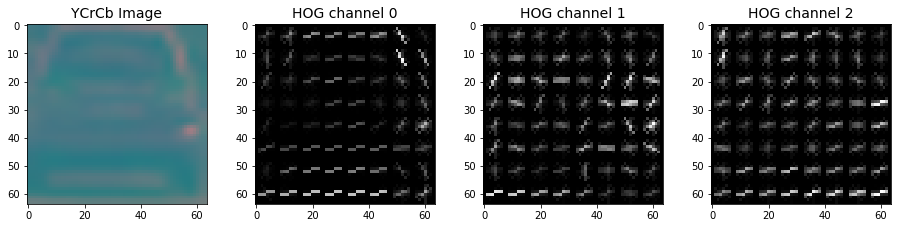

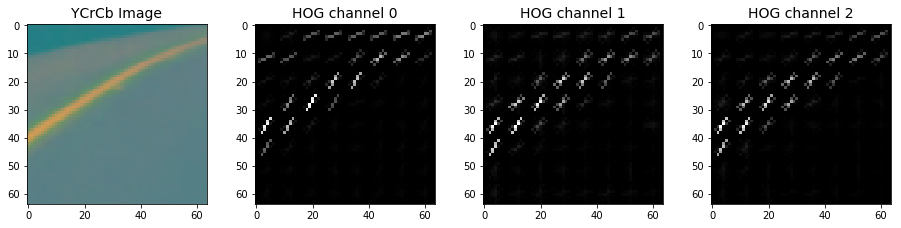

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

# CLASSIFIER's PARAMETERS
print('Loading dataset...')
# Read in cars and notcars
cars = glob.glob('dataset/vehicles/**/*.png', recursive=True)
notcars = glob.glob('dataset/non-vehicles/**/*.png', recursive=True)
# Stat
print('CARS: {}'.format(len(cars)))
print('NOTCARS: {}'.format(len(notcars)))
# Tweak these parameters
color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9          # HOG orientations
pix_per_cell   = 8          # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size   = (32, 32)   # Spatial binning dimensions
hist_bins      = 32         # Number of histogram bins
spatial_feat   = True       # Spatial features on or off
hist_feat      = True       # Histogram features on or off
hog_feat       = True       # HOG features on or off

car = mpimg.imread(cars[10])
notcar = mpimg.imread(notcars[10])
#plot_row2(car, notcar, 'Car', 'Not Car')
car_features = single_img_features(car, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)
print('car_features: DONE')
notcar_features = single_img_features(notcar, color_space=color_space,
                                      spatial_size=spatial_size, hist_bins=hist_bins, 
                                      orient=orient, pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, hog_feat=hog_feat)
print('notcar_features: DONE')

## Classifier Training Pipeline

In [12]:
# CLASSIFIER TRAINING PIPELINE
car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
print('car_features: DONE')
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)
print('notcar_features: DONE')
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

# Save data to pickle file
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )

print('Classifier parameters were saved to file')

D:\Users\MH Yap\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


car_features: DONE
notcar_features: DONE
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
21.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
Classifier parameters were saved to file


## Load Classifier Parameters

In [13]:
print('Loading Classifier parameters...')
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print('Loading is done')

Loading Classifier parameters...
Loading is done


In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
    win_pos = []
    # ADD MULTISCALING:
    for (ystart, ystop, scale) in ystart_ystop_scale:
        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = ((ch1.shape[1] // pix_per_cell) - cell_per_block + 1)
        nyblocks = ((ch1.shape[0] // pix_per_cell) - cell_per_block + 1)
        nfeat_per_block = orient * cell_per_block**2
    
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 8*8
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    

        for xb in range(nxsteps + 1):
            for yb in range(nysteps + 1):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
          
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
            
                # If detected
                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), 
                                  (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0,0,255), 2)
                    win_pos.append(((xbox_left, ytop_draw + ystart), 
                                    (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
    return draw_img, win_pos

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [15]:
# Accumulation of labels from last N frames
class LabelsQueue():
    def __init__ (self):
        # Number labels to store
        self.queue_len = 10 
        self.queue = []

    # Put new frame
    def put_labels(self, labels):
        if (len(self.queue) > self.queue_len):
            tmp = self.queue.pop(0)
        self.queue.append(labels)
    
    # Get last N frames hot boxes
    def get_labels(self):
        b = []
        for label in self.queue:
            b.extend(label)
        return b

## Vehicle Detection Pipeline

In [16]:
def detection_pipeline(img):
    out_img, win_pos = find_cars(img, svc, X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, hist_bins)
    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # AVG boxes
    last_hot_labels.put_labels(win_pos)
    win_pos = last_hot_labels.get_labels()
    
    # Add heat to each box in box list
    heat = add_heat(heat, win_pos)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 22)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    #plot_row2(img, out_img, 'Source', 'All Detections')
    #plot_row2(draw_img, heatmap, 'Car Positions', 'Heat Map')
    return labels, heatmap

In [17]:
yRange = 719

def image_pipeline(image, fontScale=0.7):
    undistorted = undistort(image)
    # Threshold image
    thresholded = threshold(image)
    # Warp image
    warped, M, Minv, warped_full = warp(thresholded)
    # Detect lane lines
    out_img, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, left_fit_m, right_fit_m = find_lines(warped_full)
    
    lane_image = draw_line(image, left_fit, right_fit, Minv)
    
    # Calculate curvature
    left_curvature = calculate_curvature(yRange, left_fit_m)
    right_curvature = calculate_curvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    message = calculate_center(image, left_fit_m, right_fit_m)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(lane_image, 'Left curvature: {:.0f} m'.format(left_curvature), (20, 50), font, fontScale, fontColor, 2)
    cv2.putText(lane_image, 'Right curvature: {:.0f} m'.format(right_curvature), (20, 120), font, fontScale, fontColor, 2)
    cv2.putText(lane_image, 'Vehicle is {} of center'.format(message), (20, 190), font, fontScale, fontColor, 2)
    
    # Vehicle detection pipeline
    labels, heatmap = detection_pipeline(undistorted)
    # Draw output
    proc_img = draw_res(lane_image, undistorted, out_img, ploty, labels, heatmap)
    #plot_row2(undistorted, proc_img, 'Undistorted', 'Result')
    return proc_img

## Final pipeline test on Images

D:\Users\MH Yap\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


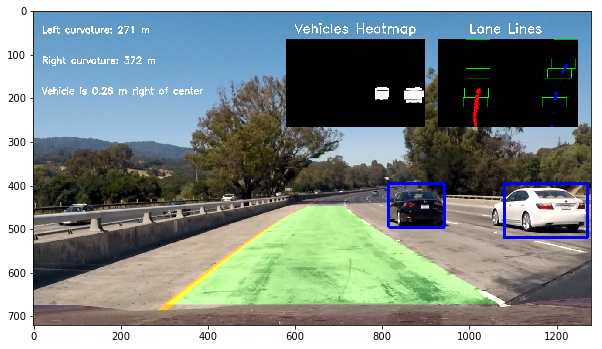

In [18]:
# Load original image from camera
last_hot_labels = LabelsQueue()
image = mpimg.imread('test_images/test1.jpg')
proc_img = image_pipeline(image)

plt.figure(figsize=(10,20))
plt.imshow(proc_img)

## Video processing

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

last_hot_labels = LabelsQueue()
video_output = 'test3.mp4'
clip = VideoFileClip('test_video3.mp4')

output_clip = clip.fl_image(image_pipeline)
%time output_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))